# Tutorial 3 - Generating Metacells for ARACNe3 network generation and VIPER protein activity analysis


This tutorial explores different approaches of generating metacells for a scRNA-seq dataset. Metacells can potentially reduce sparseness in single-cell transcriptomics and improve protein activity inference and computational efficiency. For ARACNe3's mutual information estimation, it is vital to have metacells that are independent and identically distributed. Therefore, we have implemented a weighted random sampling approach with a probability decay to disincentivize re-using the same single-cell expression profiles to create multiple metacells.



## Install Pyviper

Install pyviper from PyPI using pip. Alternatively, refer to the README in the current GitHub to install from the local directory.

In [1]:
#!pip install viper-in-python

## Import modules

In [2]:
import pyviper
import scanpy as sc
import anndata 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples

import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*") # for jit decorator issue with sc.pp.neighbors (09/30/2023)

## Step 1. Load a gene expression matrix and associated metadata

Load the same gene expression matrix (UMIs) as tutorial 2 and store it into an AnnData object to enable interoperability with scanpy. Cells used in this tutorial were sampled from scRNA-seq data published in Peng et al., 2019.

Display matrix dimensions (cells x genes)

In [3]:
gExpr_url = "https://zenodo.org/records/10059791/files/Tutorial_2_counts_mixed_4632.tsv.gz" # path to gene expression matrix (UMI counts)
adata_gExpr = pd.read_csv(gExpr_url, sep="\t") # read from remote 
adata_gExpr = sc.AnnData(adata_gExpr) # convert to AnnData object

Load cell-associated metadata. Metadata are stored on GitHub.

In [4]:
metadata_url = "https://zenodo.org/records/10059791/files/Tutorial_2_metadata_mixed_4632.tsv.gz" # path to cells metadata
cells_metadata = pd.read_csv(metadata_url, sep="\t")  # load it

Store the metadata in the adata_gExpr object as observation annotation.

In [5]:
adata_gExpr.obs = pd.merge(adata_gExpr.obs, cells_metadata, how="left",left_index=True, right_index=True) # store cell-specific metadata as annotation observation

Display the observation annotation from the AnnData object.

In [6]:
adata_gExpr.obs.head()

,Cell_Type
T1_AACCATGCACAACTGT,Ductal cell type 2
T1_AAGACCTAGTCATGCT,Ductal cell type 2
T1_ACATACGAGACTCGGA,Ductal cell type 2
T1_ACCAGTATCTTGCAAG,Ductal cell type 2
T1_ACGATGTTCACGAAGG,Ductal cell type 2


The observation annotations include the patient from which each cell was sequenced and the annotated cell type. List the cell types.

In [7]:
adata_gExpr.obs.groupby('Cell_Type').size().reset_index(name='n') # show cell types and number of cells for each type in AnnData

,Cell_Type,n
0,B cell,1000
1,Ductal cell type 2,1455
2,Fibroblast cell,1277
3,Stellate cell,900


## Step 2. Perform basic preprocessing and clustering

First, we can perform some preprocessing. The UMI matrix can be processed using the standard Scanpy preprocessing workflow. Since the quality of the provided data was pre-assessed and found to be high, cell filtering will be minimal. For a more detailed explanation of QC steps, refer to the preprocessing tutorials at Scanpy or Seurat.

If we want to generate metacells for each cell type, we eventually need to generate a nearest neighbor graph and then compute silouhette scores.

In [8]:
sc.pp.calculate_qc_metrics(adata_gExpr, inplace=True)
sc.pp.filter_cells(adata_gExpr, min_genes=200) # filter out cells with <200 genes expressed
sc.pp.filter_genes(adata_gExpr, min_cells=3) # filter out genes that are detected in <3 cells

#adata_gExpr = calcMitoRiboPercent(adata_gExpr)
#adata_gExpr = filterCellsHighMito(adata_gExpr,0.2)

sc.pp.normalize_total(adata_gExpr, inplace=True,target_sum=1e4)
sc.pp.log1p(adata_gExpr)
sc.pp.highly_variable_genes(adata_gExpr, flavor="seurat", n_top_genes=3000, inplace=True)

adata_gExpr.raw = adata_gExpr

sc.pp.scale(adata_gExpr)



## 3. Generate Metacells 

First, we will compute silhouette scores for the cells using their principal components. Then, we will pass the Anndata object with silhouette scores into pyviper's function generating metacells. This function uses a probability re-weighting approach to incentivize different minimal overlap of single cells in multiple metacells. This probability decay approach can be used with the "use_decay" and "decay_factor" parameters. 

The new dataset with generated metacells will be stored in experiment_dir_path under the subfolder with_penalty or without_penalty, depending on whether use_decay is set to True or False, respectively. For each folder, there will be further subfolders for n_cells_per_metacell. This is to aid organization, especially since one could want to compare results across different number of cells per metacell or the use of penalty.

In [9]:
sc.tl.pca(adata_gExpr, svd_solver='arpack', random_state=666)
adata_gExpr.obs["silhouette_score"] = silhouette_samples(X=adata_gExpr.obsm['X_pca'], labels=adata_gExpr.obs["Cell_Type"])



In [10]:
adata_metacell = pyviper.pp.generateMetacellAnnData(arg0=adata_gExpr,
                                         method="relative",
                                         cluster_label="Cell_Type",
                                         n_metacells=10000, #not used
                                         n_metacells_per_cluster=500,
                                         n_neighbors = 25,
                                         n_cells_per_metacell= 5, 
                                         experiment_dir_path="",
                                         use_decay=True,
                                         decay_factor= 0.10)

Good quality cells  1000


Metacells for Cluster: B cell:   0%|          | 0/200 [00:00<?, ?it/s]

(200, 20197)
Good quality cells  1455


Metacells for Cluster: Ductal cell type 2:   0%|          | 0/291 [00:00<?, ?it/s]

(200, 20197)
(291, 20197)
Good quality cells  1277


Metacells for Cluster: Fibroblast cell:   0%|          | 0/255 [00:00<?, ?it/s]

(200, 20197)
(291, 20197)
(255, 20197)
Good quality cells  900


Metacells for Cluster: Stellate cell:   0%|          | 0/180 [00:00<?, ?it/s]

(200, 20197)
(291, 20197)
(255, 20197)
(180, 20197)


/Users/av2729/opt/anaconda3/envs/single-cell-env-scvi/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


(926, 20197)


After metacells are generated, we want to ensure that the distribution of single cells and metacells is qualitatively similar in UMAP space.

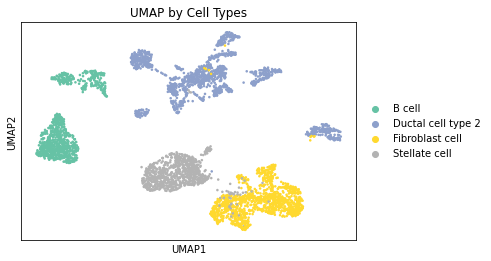

In [11]:
sc.pp.neighbors(adata_gExpr, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_gExpr)
sc.pl.umap(adata_gExpr,color = "Cell_Type", use_raw=False, palette="Set2", title = "UMAP by Cell Types")

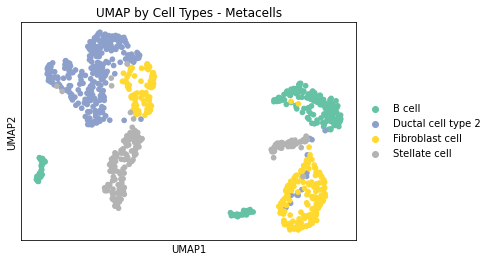

In [12]:
sc.tl.pca(adata_metacell, svd_solver='arpack', random_state=666)
sc.pp.neighbors(adata_metacell, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_metacell)
sc.pl.umap(adata_metacell,color = "Cell_Type", use_raw=False, palette="Set2", title = "UMAP by Cell Types - Metacells")

We notice that there are still two distinct clusters of B cells and of Fibroblast cells, but some B cells are not closer to Stellate cells and Fibroblast cells in UMAP space. We can perform this without a penalty to compare, and then we can also see that the distribution of cells re-used in different metacells has changed due to the penalty.

In [13]:
adata_metacell_nopenalty = pyviper.pp.generateMetacellAnnData(arg0=adata_gExpr,
                                         method="relative",
                                         cluster_label="Cell_Type",
                                         n_metacells=10000, #not used
                                         n_metacells_per_cluster=500,
                                         n_neighbors = 25,
                                         n_cells_per_metacell= 5, 
                                         experiment_dir_path="",
                                         use_decay=False) #decay factor will not matter now that use_decay is false

Good quality cells  1000


Metacells for Cluster: B cell:   0%|          | 0/200 [00:00<?, ?it/s]

(200, 20197)
Good quality cells  1455


Metacells for Cluster: Ductal cell type 2:   0%|          | 0/291 [00:00<?, ?it/s]

(200, 20197)
(291, 20197)
Good quality cells  1277


Metacells for Cluster: Fibroblast cell:   0%|          | 0/255 [00:00<?, ?it/s]

(200, 20197)
(291, 20197)
(255, 20197)
Good quality cells  900


Metacells for Cluster: Stellate cell:   0%|          | 0/180 [00:00<?, ?it/s]

(200, 20197)
(291, 20197)
(255, 20197)
(180, 20197)


/Users/av2729/opt/anaconda3/envs/single-cell-env-scvi/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


(926, 20197)


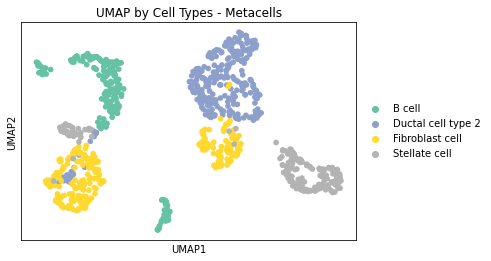

In [14]:
sc.tl.pca(adata_metacell_nopenalty, svd_solver='arpack', random_state=666)
sc.pp.neighbors(adata_metacell_nopenalty, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_metacell_nopenalty)
sc.pl.umap(adata_metacell_nopenalty,color = "Cell_Type", use_raw=False, palette="Set2", title = "UMAP by Cell Types - Metacells")

We observe a similar general distribution of metacells in UMAP space. We can quantitatively identify whether a penalty achieves our desired goal of minimizing overlap across metacells.

In [15]:
#this works if you are working on the source directory of the jupyter notebook
metacell_counts_penalty = pd.read_csv("with_penalty/5/metacell_counts_5.csv")
metacell_counts_nopenalty = pd.read_csv("without_penalty/5/metacell_counts_5.csv")

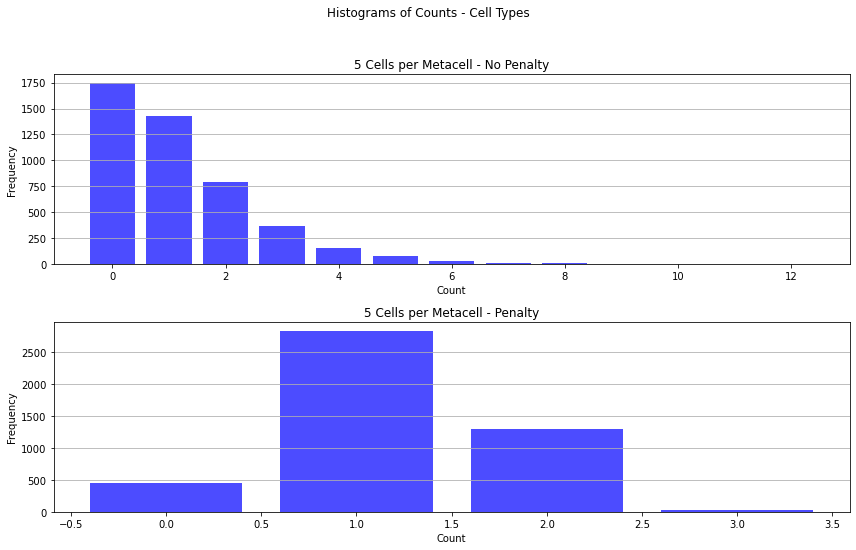

In [16]:
# Create and save histograms and bar plots for the cluster
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle(f"Histograms of Counts - Cell Types")

# Plot histograms for "Penalty" and "No Penalty", 5 and 10 cells per metacell
def plot_bar(ax, data, title):
    unique_counts = data["Count"].value_counts().sort_index()
    counts = unique_counts.index
    frequencies = unique_counts.values
    ax.bar(counts, frequencies, width=0.8, color="blue", alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("Count")
    ax.set_ylabel("Frequency")
    ax.grid(axis="y")
    
plot_bar(axes[0], metacell_counts_nopenalty, "5 Cells per Metacell - No Penalty")
plot_bar(axes[1], metacell_counts_penalty, "5 Cells per Metacell - Penalty")

# Add labels
for ax in axes.flat:
    ax.set(xlabel="Count", ylabel="Frequency")

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])




Using a probability penalty, we have changed from a right tailed distribution to one that peaks at 1, indicating that most of the single cells are selected only once in a metacell. 

Now, the metacell datasets can be used to build ARACNe3 networks which can then be used for Py-VIPER analysis.